# 02 - Stratégies de Vectorisation

**Objectif**: Trouver la meilleure méthode de représentation des features textuelles.

**Méthodologie**:
- **Modèle fixé**: Logistic Regression (contrôle de variable)
- **Preprocessing**: `final_text_cleaner()` (from Notebook 01)
- **Variables testées**: Vectorizer, Features, Strategy, Hyperparamètres

**Output**: Configuration optimale → `configs/best_vectorization_config.json`

## 1. Setup & Configuration

In [1]:
import sys
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '../../src')
sys.path.insert(0, '../../scripts')

# Imports Phase 2
from rakuten_text import (
    # Preprocessing (Phase 1)
    final_text_cleaner,
    
    # Features
    extract_text_features,
    
    # Vectorization
    save_vectorization_config,
    
    # Experiments
    run_single_experiment,
    run_strategy_comparison,
    run_hyperparameter_grid,
    run_title_weighting_experiment,
    analyze_experiment_results,
    generate_vectorization_report,
)

from sklearn.model_selection import train_test_split

# Import data loading with consistent split
from load_data import split_data

print("✓ Imports réussis")

✓ Imports réussis


## 2. Chargement et Preprocessing

In [2]:
# Load data with consistent split (same as NB01)
X_dev, X_holdout, y_dev, y_holdout = split_data()

# Prepare dataframes
df_dev = X_dev.copy()
df_dev['prdtypecode'] = y_dev

df_holdout = X_holdout.copy()
df_holdout['prdtypecode'] = y_holdout

print(f"✓ {df_dev.shape[0]} samples loaded")
print(f"✓ Development: {len(df_dev):,} samples (85%)")
print(f"✓ Hold-out:    {len(df_holdout):,} samples (15%)")
print("⚠️  Hold-out will be evaluated at the end only!")

# Apply preprocessing (from Notebook 01)
print("\nApplying preprocessing...")
df_dev['title_clean'] = df_dev['designation'].fillna('').apply(final_text_cleaner)
df_dev['desc_clean'] = df_dev['description'].fillna('').apply(final_text_cleaner)

df_holdout['title_clean'] = df_holdout['designation'].fillna('').apply(final_text_cleaner)
df_holdout['desc_clean'] = df_holdout['description'].fillna('').apply(final_text_cleaner)

print("✓ Texts cleaned (dev + holdout)")

✓ 72178 samples loaded
✓ Development: 72,178 samples (85%)
✓ Hold-out:    12,738 samples (15%)
⚠️  Hold-out will be evaluated at the end only!

Applying preprocessing...
✓ Texts cleaned (dev + holdout)


## 3. Feature Engineering

In [3]:
# Extract manual features (on dev + holdout)
print("="*80)
print("Feature Engineering")
print("="*80)

features_dev = extract_text_features(
    df_dev,
    text_columns=['designation', 'description'],
    verbose=True
)

features_holdout = extract_text_features(
    df_holdout,
    text_columns=['designation', 'description'],
    verbose=False
)

# Add to DataFrame
for col in features_dev.columns:
    df_dev[col] = features_dev[col]
    df_holdout[col] = features_holdout[col]

feature_columns = list(features_dev.columns)
print(f"\n✓ {len(feature_columns)} features extracted")
print(f"Features: {feature_columns[:3]}...")

Feature Engineering
Extraction des features manuelles...
  Colonnes à analyser: ['designation', 'description']
  → Traitement de 'designation'...
  → Traitement de 'description'...
✓ Extraction terminée: 12 features créées
  Noms: ['designation_len_char', 'designation_len_words', 'designation_num_digits']...

✓ 12 features extracted
Features: ['designation_len_char', 'designation_len_words', 'designation_num_digits']...


## 4. Train/Val Split

In [4]:
# Development Split (Train/Val)
print("\n" + "="*80)
print("Development Split (Train/Val)")
print("="*80)

VAL_SIZE = 0.15
RANDOM_STATE = 42

X_train, X_val, y_train, y_val = train_test_split(
    df_dev,
    df_dev['prdtypecode'],
    test_size=VAL_SIZE,
    stratify=df_dev['prdtypecode'],
    random_state=RANDOM_STATE
)

total_samples = len(df_dev) + len(df_holdout)
print(f"✓ Split complete:")
print(f"  Train:      {len(X_train):,} (~{len(X_train)/total_samples*100:.1f}%)")
print(f"  Validation: {len(X_val):,} (~{len(X_val)/total_samples*100:.1f}%)")
print(f"  Hold-out:   {len(df_holdout):,} (15.0%)")

print("\n⚠️  Model selection will use Train/Val only")
print("⚠️  Hold-out will be evaluated at the end")
print("=" * 80)


Development Split (Train/Val)
✓ Split complete:
  Train:      61,351 (~72.2%)
  Validation: 10,827 (~12.8%)
  Hold-out:   12,738 (15.0%)

⚠️  Model selection will use Train/Val only
⚠️  Hold-out will be evaluated at the end


## 5. Expérience 1: Comparaison Vectorization Methods

Test: Count vs TF-IDF (sans features manuelles)

In [5]:
# baseline_raw_f1 from Notebook 01
baseline_f1 = 0.7925

print("Test 1: Count vs TF-IDF (Split, sans features)\n")

results_vec = []

# TF-IDF Split
result_tfidf = run_single_experiment(
    X_train, X_val, y_train, y_val,
    vectorizer_type='tfidf',
    strategy='split',
    text_columns=['title_clean', 'desc_clean'],
    feature_columns=None,
    max_features=10000,
    ngram_range=(1, 2),
    model_name='logreg',
    verbose=True
)

results_vec.append({
    'method': 'TF-IDF Split',
    'f1_score': result_tfidf['f1_score'],
    'accuracy': result_tfidf['accuracy']
})

# Count Split
result_count = run_single_experiment(
    X_train, X_val, y_train, y_val,
    vectorizer_type='count',
    strategy='split',
    text_columns=['title_clean', 'desc_clean'],
    feature_columns=None,
    max_features=10000,
    ngram_range=(1, 2),
    model_name='logreg',
    verbose=True
)

results_vec.append({
    'method': 'Count Split',
    'f1_score': result_count['f1_score'],
    'accuracy': result_count['accuracy']
})

df_vec = pd.DataFrame(results_vec)
print("\n" + "="*60)
print("RÉSULTATS:")
print(df_vec.to_string(index=False))
print("="*60)

Test 1: Count vs TF-IDF (Split, sans features)


Expérience: TFIDF + LOGREG
  Strategy: split
  Max features: 10000
  N-gram range: (1, 2)
  Features manuelles: Non

Entraînement du pipeline...
✓ Entraînement terminé en 29.15s

RÉSULTATS DE L'ÉVALUATION
F1-Score (weighted): 0.8246
Accuracy:            0.8241
Temps prédiction:    1.31s

Rapport de classification:
--------------------------------------------------------------------------------
                        precision    recall  f1-score   support

     Livres techniques       0.50      0.65      0.56       397
          Rétro Gaming       0.73      0.68      0.71       320
        Accessoires JV       0.83      0.82      0.82       214
              Consoles       0.99      0.77      0.87       106
              Figurine       0.78      0.78      0.78       341
Cartes à collectionner       0.90      0.94      0.92       504
          Jeux de rôle       0.92      0.59      0.72        97
    Jouets & Figurines       0.72      0.

## 6. Expérience 2: Split vs Merged Strategy

Comparaison détaillée des deux stratégies

In [6]:
print("Test 2: Split vs Merged (TF-IDF)\n")

# Créer colonne merged pour test
X_train['text_merged'] = X_train['title_clean'] + ' ' + X_train['desc_clean']
X_val['text_merged'] = X_val['title_clean'] + ' ' + X_val['desc_clean']

# TF-IDF Merged
result_merged = run_single_experiment(
    X_train, X_val, y_train, y_val,
    vectorizer_type='tfidf',
    strategy='merged',
    text_columns=['text_merged'],
    feature_columns=None,
    max_features=10000,
    ngram_range=(1, 2),
    model_name='logreg',
    verbose=True
)

print("\n" + "="*60)
print("COMPARAISON Split vs Merged:")
print(f"  Split:  F1 = {result_tfidf['f1_score']:.4f}")
print(f"  Merged: F1 = {result_merged['f1_score']:.4f}")
improvement = (result_tfidf['f1_score'] - result_merged['f1_score']) / result_merged['f1_score'] * 100
print(f"  → Split est {improvement:+.2f}% meilleur")
print("="*60)

Test 2: Split vs Merged (TF-IDF)


Expérience: TFIDF + LOGREG
  Strategy: merged
  Max features: 10000
  N-gram range: (1, 2)
  Features manuelles: Non

Entraînement du pipeline...
✓ Entraînement terminé en 26.82s

RÉSULTATS DE L'ÉVALUATION
F1-Score (weighted): 0.7848
Accuracy:            0.7854
Temps prédiction:    1.35s

Rapport de classification:
--------------------------------------------------------------------------------
                        precision    recall  f1-score   support

     Livres techniques       0.44      0.61      0.51       397
          Rétro Gaming       0.71      0.62      0.66       320
        Accessoires JV       0.76      0.81      0.78       214
              Consoles       0.97      0.74      0.84       106
              Figurine       0.73      0.74      0.74       341
Cartes à collectionner       0.87      0.89      0.88       504
          Jeux de rôle       0.82      0.37      0.51        97
    Jouets & Figurines       0.64      0.63      0.64 

In [7]:
from sklearn.metrics import classification_report
from rakuten_text.categories import get_all_categories

print("="*80)
print("PER-CLASS ANALYSIS: Split vs Merged Performance")
print("="*80)

# Get predictions from both strategies (using existing result_merged from Cell 12)
pipeline_split = result_tfidf['pipeline']
pipeline_merged = result_merged['pipeline']

y_pred_split = pipeline_split.predict(X_val)
y_pred_merged = pipeline_merged.predict(X_val)

# Classification reports
report_split = classification_report(y_val, y_pred_split, output_dict=True, zero_division=0)
report_merged = classification_report(y_val, y_pred_merged, output_dict=True, zero_division=0)

# Load category mapping from categories.py
categories = get_all_categories(short=True)

# Compare per category
comparison_data = []
for code in sorted(categories.keys()):
    cat_name = categories[code]
    f1_split = report_split.get(str(code), {}).get('f1-score', 0)
    f1_merged = report_merged.get(str(code), {}).get('f1-score', 0)
    
    comparison_data.append({
        'code': code,
        'category': cat_name,
        'split_f1': f1_split,
        'merged_f1': f1_merged,
        'diff': f1_split - f1_merged,
        'pct_change': (f1_split - f1_merged) / f1_merged * 100 if f1_merged > 0 else 0
    })

df_comp = pd.DataFrame(comparison_data)
df_comp = df_comp.sort_values('diff', ascending=False)

print("\nNote: Comparing Split (20k total) vs Merged (10k total)")
print("For fair comparison with equal features, see Cell 15 below")
print()

print("Top 10 categories benefiting most from Split strategy:")
print(df_comp.head(10)[['category', 'split_f1', 'merged_f1', 'diff', 'pct_change']].to_string(index=False))

print("\nBottom 10 categories (least benefit from Split):")
print(df_comp.tail(10)[['category', 'split_f1', 'merged_f1', 'diff', 'pct_change']].to_string(index=False))

# Statistical summary
print(f"\nSummary Statistics:")
print(f"  Categories improved by Split: {(df_comp['diff'] > 0).sum()} / {len(df_comp)}")
print(f"  Average improvement: {df_comp['diff'].mean():+.4f}")
print(f"  Median improvement: {df_comp['diff'].median():+.4f}")
print(f"  Std deviation: {df_comp['diff'].std():.4f}")
print("="*80)

PER-CLASS ANALYSIS: Split vs Merged Performance

Note: Comparing Split (20k total) vs Merged (10k total)
For fair comparison with equal features, see Cell 15 below

Top 10 categories benefiting most from Split strategy:
              category  split_f1  merged_f1     diff  pct_change
          Jeux de rôle  0.716981   0.510638 0.206343   40.408805
    Jouets & Figurines  0.737910   0.637398 0.100511   15.768967
    Modélisme & Drones  0.956659   0.881688 0.074971    8.503095
           Bébé & Jeux  0.933333   0.864583 0.068750    7.951807
        Jeux éducatifs  0.628205   0.559653 0.068552   12.249056
     Livres techniques  0.563319   0.510549 0.052770   10.335992
       Sport & Loisirs  0.804636   0.754325 0.050311    6.669603
          Rétro Gaming  0.707593   0.660000 0.047593    7.211044
Cartes à collectionner  0.921283   0.877331 0.043952    5.009751
              Figurine  0.779412   0.735465 0.043947    5.975355

Bottom 10 categories (least benefit from Split):
            cat

## 6c. Per-Class Analysis: Which Categories Benefit from Split?

In [8]:
print("="*80)
print("FAIR COMPARISON: Split vs Merged (Equal Feature Capacity)")
print("="*80)

# Scenario A: Control total features at 10,000
print("\nScenario A: Total 10k features")
print("-"*80)

# Split: 5k per column
result_split_5k = run_single_experiment(
    X_train, X_val, y_train, y_val,
    vectorizer_type='tfidf',
    strategy='split',
    text_columns=['title_clean', 'desc_clean'],
    feature_columns=None,
    max_features=5000,
    ngram_range=(1, 2),
    model_name='logreg',
    verbose=True
)

print(f"\nResults (10k total features):")
print(f"  Split (5k/col):  F1 = {result_split_5k['f1_score']:.4f}")
print(f"  Merged (10k):    F1 = {result_merged['f1_score']:.4f}")
diff_10k = result_split_5k['f1_score'] - result_merged['f1_score']
print(f"  Difference:      {diff_10k:+.4f} ({diff_10k/result_merged['f1_score']*100:+.2f}%)")

# Scenario B: Control total features at 20,000
print("\n" + "="*80)
print("Scenario B: Total 20k features")
print("-"*80)

# Merged: 20k total
result_merged_20k = run_single_experiment(
    X_train, X_val, y_train, y_val,
    vectorizer_type='tfidf',
    strategy='merged',
    text_columns=['text_merged'],
    feature_columns=None,
    max_features=20000,
    ngram_range=(1, 2),
    model_name='logreg',
    verbose=True
)

print(f"\nResults (20k total features):")
print(f"  Split (10k/col): F1 = {result_tfidf['f1_score']:.4f}")
print(f"  Merged (20k):    F1 = {result_merged_20k['f1_score']:.4f}")
diff_20k = result_tfidf['f1_score'] - result_merged_20k['f1_score']
print(f"  Difference:      {diff_20k:+.4f} ({diff_20k/result_merged_20k['f1_score']*100:+.2f}%)")

# Summary
print("\n" + "="*80)
print("FAIR COMPARISON SUMMARY")
print("="*80)
print(f"10k total features: Split advantage = {diff_10k:+.4f}")
print(f"20k total features: Split advantage = {diff_20k:+.4f}")

if diff_10k > 0 and diff_20k > 0:
    print("\nConclusion: Split strategy is genuinely better")
    print("(advantage persists across both feature capacity levels)")
elif diff_10k > 0 and diff_20k <= 0:
    print("\nConclusion: Split advantage mainly from higher feature count")
    print("(not from strategy itself)")
else:
    print("\nConclusion: Results inconsistent, needs investigation")
print("="*80)

FAIR COMPARISON: Split vs Merged (Equal Feature Capacity)

Scenario A: Total 10k features
--------------------------------------------------------------------------------

Expérience: TFIDF + LOGREG
  Strategy: split
  Max features: 5000
  N-gram range: (1, 2)
  Features manuelles: Non

Entraînement du pipeline...
✓ Entraînement terminé en 22.86s

RÉSULTATS DE L'ÉVALUATION
F1-Score (weighted): 0.8147
Accuracy:            0.8136
Temps prédiction:    0.79s

Rapport de classification:
--------------------------------------------------------------------------------
                        precision    recall  f1-score   support

     Livres techniques       0.47      0.66      0.55       397
          Rétro Gaming       0.75      0.67      0.71       320
        Accessoires JV       0.82      0.81      0.81       214
              Consoles       0.99      0.78      0.87       106
              Figurine       0.76      0.77      0.76       341
Cartes à collectionner       0.90      0.92    

## 6b. FIX: Fair Split vs Merged Comparison

**Issue**: Previous comparison was unfair
- Split: 2 columns × 10k = 20k total features
- Merged: 1 column × 10k = 10k total features

**Fix**: Test both strategies with equal feature capacity

from sklearn.metrics import classification_report
from rakuten_text.categories import get_all_categories

print("="*80)
print("PER-CLASS ANALYSIS: Split vs Merged Performance")
print("="*80)

# Get predictions from both strategies (using existing result_merged from Cell 12)
pipeline_split = result_tfidf['pipeline']
pipeline_merged = result_merged['pipeline']

y_pred_split = pipeline_split.predict(X_val)
y_pred_merged = pipeline_merged.predict(X_val)

# Classification reports
report_split = classification_report(y_val, y_pred_split, output_dict=True, zero_division=0)
report_merged = classification_report(y_val, y_pred_merged, output_dict=True, zero_division=0)

# Load category mapping from categories.py
categories = get_all_categories(short=True)

# Compare per category
comparison_data = []
for code in sorted(categories.keys()):
    cat_name = categories[code]
    f1_split = report_split.get(str(code), {}).get('f1-score', 0)
    f1_merged = report_merged.get(str(code), {}).get('f1-score', 0)
    
    comparison_data.append({
        'code': code,
        'category': cat_name,
        'split_f1': f1_split,
        'merged_f1': f1_merged,
        'diff': f1_split - f1_merged,
        'pct_change': (f1_split - f1_merged) / f1_merged * 100 if f1_merged > 0 else 0
    })

df_comp = pd.DataFrame(comparison_data)
df_comp = df_comp.sort_values('diff', ascending=False)

print("\nNote: Comparing Split (20k total) vs Merged (10k total)")
print("For fair comparison with equal features, see Cell 15 below")
print()

print("Top 10 categories benefiting most from Split strategy:")
print(df_comp.head(10)[['category', 'split_f1', 'merged_f1', 'diff', 'pct_change']].to_string(index=False))

print("\nBottom 10 categories (least benefit from Split):")
print(df_comp.tail(10)[['category', 'split_f1', 'merged_f1', 'diff', 'pct_change']].to_string(index=False))

# Statistical summary
print(f"\nSummary Statistics:")
print(f"  Categories improved by Split: {(df_comp['diff'] > 0).sum()} / {len(df_comp)}")
print(f"  Average improvement: {df_comp['diff'].mean():+.4f}")
print(f"  Median improvement: {df_comp['diff'].median():+.4f}")
print(f"  Std deviation: {df_comp['diff'].std():.4f}")
print("="*80)

In [9]:
print("Test 2b: Pondération du Titre (TF-IDF Split)\n")

# Tester différents poids pour le titre: 1x, 1.5x, 2x, 2.5x, 3x
results_weighting = run_title_weighting_experiment(
    X_train, X_val, y_train, y_val,
    text_columns=['title_clean', 'desc_clean'],
    feature_columns=None,  # Sans features manuelles pour isoler l'effet
    title_weights=[1.0, 1.5, 2.0, 2.5, 3.0],
    vectorizer_type='tfidf',
    max_features=10000,
    ngram_range=(1, 2),
    model_name='logreg',
    verbose=True
)

print("\n✓ Test de pondération terminé")

Test 2b: Pondération du Titre (TF-IDF Split)


TEST DE PONDÉRATION DU TITRE
Poids à tester: [1.0, 1.5, 2.0, 2.5, 3.0]
Vectorizer: TFIDF
Max features: 10000 (par colonne)
N-gram range: (1, 2)
Modèle: LOGREG


[1/5] Test avec title_weight = 1.0x
--------------------------------------------------------------------------------
  → F1-Score: 0.8246
  → Accuracy: 0.8241
  → Train time: 28.26s

[2/5] Test avec title_weight = 1.5x
--------------------------------------------------------------------------------
  → F1-Score: 0.8256
  → Accuracy: 0.8253
  → Train time: 27.07s

[3/5] Test avec title_weight = 2.0x
--------------------------------------------------------------------------------
  → F1-Score: 0.8238
  → Accuracy: 0.8235
  → Train time: 26.66s

[4/5] Test avec title_weight = 2.5x
--------------------------------------------------------------------------------
  → F1-Score: 0.8224
  → Accuracy: 0.8219
  → Train time: 23.34s

[5/5] Test avec title_weight = 3.0x
------------------------

In [10]:
print("="*80)
print("PARAMETER INTERACTION ANALYSIS")
print("="*80)
print("\nQuestion: Is title_weight=1.5x optimal under different configurations?")
print("Testing under 4 scenarios with varying max_features and ngram_range")
print("-"*80)

# Define test scenarios
scenarios = [
    {'max_features': 10000, 'ngram_range': (1, 2), 'name': 'Baseline (10k, bigrams)'},
    {'max_features': 10000, 'ngram_range': (1, 1), 'name': 'Unigrams only (10k)'},
    {'max_features': 20000, 'ngram_range': (1, 1), 'name': 'Optimal from Grid (20k, unigrams)'},
    {'max_features': 5000, 'ngram_range': (1, 2), 'name': 'Low capacity (5k, bigrams)'}
]

# Test weights for each scenario
test_weights = [1.0, 1.5, 2.0]

results_interaction = []

for scenario in scenarios:
    print(f"\n{'='*80}")
    print(f"Scenario: {scenario['name']}")
    print(f"  max_features: {scenario['max_features']}, ngram_range: {scenario['ngram_range']}")
    print(f"{'='*80}")
    
    scenario_results = []
    
    for weight in test_weights:
        # Run experiment
        result = run_single_experiment(
            X_train, X_val, y_train, y_val,
            vectorizer_type='tfidf',
            strategy='split',
            text_columns=['title_clean', 'desc_clean'],
            feature_columns=None,
            max_features=scenario['max_features'],
            ngram_range=scenario['ngram_range'],
            title_weight=weight,
            model_name='logreg',
            verbose=False
        )
        
        scenario_results.append({
            'scenario': scenario['name'],
            'max_features': scenario['max_features'],
            'ngram_range': str(scenario['ngram_range']),
            'title_weight': weight,
            'f1_score': result['f1_score']
        })
        
        print(f"  Weight {weight}x: F1 = {result['f1_score']:.4f}")
    
    # Find best weight for this scenario
    best_in_scenario = max(scenario_results, key=lambda x: x['f1_score'])
    print(f"  → Best: {best_in_scenario['title_weight']}x (F1={best_in_scenario['f1_score']:.4f})")
    
    results_interaction.extend(scenario_results)

# Summary analysis
print("\n" + "="*80)
print("INTERACTION SUMMARY")
print("="*80)

df_interaction = pd.DataFrame(results_interaction)

# Pivot table for visualization
pivot = df_interaction.pivot_table(
    values='f1_score',
    index='scenario',
    columns='title_weight',
    aggfunc='first'
)

print("\nF1 Scores by Scenario and Title Weight:")
print(pivot.to_string())

# Find best weight for each scenario
print("\n" + "-"*80)
print("Optimal title_weight per scenario:")
print("-"*80)
for scenario_name in df_interaction['scenario'].unique():
    scenario_data = df_interaction[df_interaction['scenario'] == scenario_name]
    best_row = scenario_data.loc[scenario_data['f1_score'].idxmax()]
    print(f"{scenario_name:40s} → {best_row['title_weight']}x (F1={best_row['f1_score']:.4f})")

# Count how many scenarios prefer each weight
print("\n" + "-"*80)
print("Weight preference distribution:")
print("-"*80)
best_weights = []
for scenario_name in df_interaction['scenario'].unique():
    scenario_data = df_interaction[df_interaction['scenario'] == scenario_name]
    best_weight = scenario_data.loc[scenario_data['f1_score'].idxmax()]['title_weight']
    best_weights.append(best_weight)

from collections import Counter
weight_counts = Counter(best_weights)
for weight in sorted(weight_counts.keys()):
    count = weight_counts[weight]
    print(f"  Weight {weight}x: {count}/{len(scenarios)} scenarios")

print("\n" + "="*80)
print("CONCLUSION")
print("="*80)
if weight_counts[1.5] >= len(scenarios) / 2:
    print("✓ Title weight 1.5x is robust across different configurations")
    print("  (optimal or near-optimal in majority of scenarios)")
else:
    majority_weight = max(weight_counts.items(), key=lambda x: x[1])[0]
    print(f"⚠ Parameter interaction detected!")
    print(f"  Weight {majority_weight}x is preferred in most scenarios")
    print(f"  May need to adjust title_weight based on other hyperparameters")
print("="*80)

PARAMETER INTERACTION ANALYSIS

Question: Is title_weight=1.5x optimal under different configurations?
Testing under 4 scenarios with varying max_features and ngram_range
--------------------------------------------------------------------------------

Scenario: Baseline (10k, bigrams)
  max_features: 10000, ngram_range: (1, 2)

Expérience: TFIDF + LOGREG
  Strategy: split
  Max features: 10000
  N-gram range: (1, 2)
  Features manuelles: Non

  Weight 1.0x: F1 = 0.8246

Expérience: TFIDF + LOGREG
  Strategy: split
  Max features: 10000
  N-gram range: (1, 2)
  Features manuelles: Non

  Weight 1.5x: F1 = 0.8256

Expérience: TFIDF + LOGREG
  Strategy: split
  Max features: 10000
  N-gram range: (1, 2)
  Features manuelles: Non

  Weight 2.0x: F1 = 0.8238
  → Best: 1.5x (F1=0.8256)

Scenario: Unigrams only (10k)
  max_features: 10000, ngram_range: (1, 1)

Expérience: TFIDF + LOGREG
  Strategy: split
  Max features: 10000
  N-gram range: (1, 1)
  Features manuelles: Non

  Weight 1.0x: F

## 6e. Parameter Interaction: Title Weight Consistency

Test whether optimal title_weight (1.5x) holds across different hyperparameter configurations.

In [11]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy import stats
import numpy as np

print("="*80)
print("STATISTICAL VALIDATION: Cross-Validation + Significance Testing")
print("="*80)

# Select weights to validate: baseline (1.0), optimal (1.5), and alternative (2.0)
weights_to_validate = [1.0, 1.5, 2.0]
n_folds = 5

print(f"\nRunning {n_folds}-fold cross-validation for title weights: {weights_to_validate}")
print(f"Dataset: Development set ({len(df_dev)} samples)")
print("-"*80)

# Store CV scores for each weight
cv_scores_by_weight = {}

for weight in weights_to_validate:
    print(f"\nTitle weight = {weight}x")
    print("-"*40)
    
    # Import pipeline components
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LogisticRegression
    from rakuten_text.vectorization import FeatureWeighter
    from sklearn.feature_extraction.text import TfidfVectorizer
    from scipy.sparse import hstack
    
    # Build pipeline for this weight
    tfidf_title = TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )
    
    tfidf_desc = TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )
    
    # Prepare cross-validation
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(df_dev, y_dev), 1):
        X_fold_train = df_dev.iloc[train_idx]
        X_fold_val = df_dev.iloc[val_idx]
        y_fold_train = y_dev.iloc[train_idx]
        y_fold_val = y_dev.iloc[val_idx]
        
        # Vectorize
        title_train = tfidf_title.fit_transform(X_fold_train['title_clean'])
        title_val = tfidf_title.transform(X_fold_val['title_clean'])
        
        desc_train = tfidf_desc.fit_transform(X_fold_train['desc_clean'])
        desc_val = tfidf_desc.transform(X_fold_val['desc_clean'])
        
        # Apply weighting
        if weight != 1.0:
            title_train = title_train * weight
            title_val = title_val * weight
        
        # Combine
        X_fold_train_vec = hstack([title_train, desc_train])
        X_fold_val_vec = hstack([title_val, desc_val])
        
        # Train and evaluate
        clf = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
        clf.fit(X_fold_train_vec, y_fold_train)
        
        from sklearn.metrics import f1_score
        y_pred = clf.predict(X_fold_val_vec)
        fold_f1 = f1_score(y_fold_val, y_pred, average='weighted')
        fold_scores.append(fold_f1)
        
        print(f"  Fold {fold_idx}: F1 = {fold_f1:.4f}")
    
    cv_scores_by_weight[weight] = fold_scores
    mean_f1 = np.mean(fold_scores)
    std_f1 = np.std(fold_scores)
    
    print(f"  Mean F1: {mean_f1:.4f} ± {std_f1:.4f}")
    print(f"  95% CI: [{mean_f1 - 1.96*std_f1/np.sqrt(n_folds):.4f}, {mean_f1 + 1.96*std_f1/np.sqrt(n_folds):.4f}]")

# Statistical significance testing
print("\n" + "="*80)
print("PAIRED T-TESTS (Comparing title weights)")
print("="*80)

baseline_scores = cv_scores_by_weight[1.0]
optimal_scores = cv_scores_by_weight[1.5]
alternative_scores = cv_scores_by_weight[2.0]

# Test 1: Optimal (1.5x) vs Baseline (1.0x)
t_stat_1, p_value_1 = stats.ttest_rel(optimal_scores, baseline_scores)
print(f"\nTest 1: Weight 1.5x vs 1.0x (baseline)")
print(f"  Mean improvement: {np.mean(optimal_scores) - np.mean(baseline_scores):+.4f}")
print(f"  t-statistic: {t_stat_1:.4f}")
print(f"  p-value: {p_value_1:.4f}")
print(f"  Significant at α=0.05? {'YES' if p_value_1 < 0.05 else 'NO'}")

# Test 2: Alternative (2.0x) vs Baseline (1.0x)
t_stat_2, p_value_2 = stats.ttest_rel(alternative_scores, baseline_scores)
print(f"\nTest 2: Weight 2.0x vs 1.0x (baseline)")
print(f"  Mean improvement: {np.mean(alternative_scores) - np.mean(baseline_scores):+.4f}")
print(f"  t-statistic: {t_stat_2:.4f}")
print(f"  p-value: {p_value_2:.4f}")
print(f"  Significant at α=0.05? {'YES' if p_value_2 < 0.05 else 'NO'}")

# Test 3: Optimal (1.5x) vs Alternative (2.0x)
t_stat_3, p_value_3 = stats.ttest_rel(optimal_scores, alternative_scores)
print(f"\nTest 3: Weight 1.5x vs 2.0x")
print(f"  Mean difference: {np.mean(optimal_scores) - np.mean(alternative_scores):+.4f}")
print(f"  t-statistic: {t_stat_3:.4f}")
print(f"  p-value: {p_value_3:.4f}")
print(f"  Significant at α=0.05? {'YES' if p_value_3 < 0.05 else 'NO'}")

print("\n" + "="*80)
print("CONCLUSION")
print("="*80)
print(f"Baseline (1.0x): F1 = {np.mean(baseline_scores):.4f} ± {np.std(baseline_scores):.4f}")
print(f"Optimal  (1.5x): F1 = {np.mean(optimal_scores):.4f} ± {np.std(optimal_scores):.4f}")
print(f"Alternative (2.0x): F1 = {np.mean(alternative_scores):.4f} ± {np.std(alternative_scores):.4f}")

if p_value_1 < 0.05:
    print(f"\n✓ Title weight 1.5x provides statistically significant improvement over baseline")
else:
    print(f"\n⚠ Title weight 1.5x improvement is NOT statistically significant (p={p_value_1:.4f})")
    
print("="*80)

STATISTICAL VALIDATION: Cross-Validation + Significance Testing

Running 5-fold cross-validation for title weights: [1.0, 1.5, 2.0]
Dataset: Development set (72178 samples)
--------------------------------------------------------------------------------

Title weight = 1.0x
----------------------------------------
  Fold 1: F1 = 0.8170
  Fold 2: F1 = 0.8155
  Fold 3: F1 = 0.8226
  Fold 4: F1 = 0.8187
  Fold 5: F1 = 0.8159
  Mean F1: 0.8179 ± 0.0026
  95% CI: [0.8157, 0.8202]

Title weight = 1.5x
----------------------------------------
  Fold 1: F1 = 0.8205
  Fold 2: F1 = 0.8187
  Fold 3: F1 = 0.8264
  Fold 4: F1 = 0.8237
  Fold 5: F1 = 0.8213
  Mean F1: 0.8221 ± 0.0027
  95% CI: [0.8198, 0.8245]

Title weight = 2.0x
----------------------------------------
  Fold 1: F1 = 0.8203
  Fold 2: F1 = 0.8183
  Fold 3: F1 = 0.8254
  Fold 4: F1 = 0.8237
  Fold 5: F1 = 0.8213
  Mean F1: 0.8218 ± 0.0025
  95% CI: [0.8196, 0.8240]

PAIRED T-TESTS (Comparing title weights)

Test 1: Weight 1.5x vs 1.

## 6d. Statistical Validation: Title Weighting with Cross-Validation

Validate that title weighting improvement is statistically significant and not due to random variation.

## 7. Expérience 3: Impact des Features Manuelles

Test des 5 stratégies complètes

In [12]:
print("Test 3: Impact des features manuelles\n")

# Utiliser la fonction run_strategy_comparison
results_strategies = run_strategy_comparison(
    X_train, X_val, y_train, y_val,
    text_columns=['title_clean', 'desc_clean'],
    feature_columns=feature_columns,
    models=['logreg'],  # Seul LogReg pour contrôle
    max_features=10000,
    ngram_range=(1, 2),
    verbose=True
)

print("\n✓ Comparaison terminée")

Test 3: Impact des features manuelles


COMPARAISON COMPLÈTE DES STRATÉGIES DE VECTORISATION
Modèles à tester: ['logreg']
Max features: 10000
N-gram range: (1, 2)


📊 STRATÉGIE 1: Indicateurs seuls
--------------------------------------------------------------------------------
  Modèle: LOGREG
    F1: 0.2920, Acc: 0.3400


📊 STRATÉGIE 2: CountVectorizer seul
--------------------------------------------------------------------------------
  Modèle: LOGREG

Expérience: COUNT + LOGREG
  Strategy: split
  Max features: 10000
  N-gram range: (1, 2)
  Features manuelles: Non

    F1: 0.8167, Acc: 0.8153


📊 STRATÉGIE 3: TF-IDF seul
--------------------------------------------------------------------------------
  Modèle: LOGREG

Expérience: TFIDF + LOGREG
  Strategy: split
  Max features: 10000
  N-gram range: (1, 2)
  Features manuelles: Non

    F1: 0.8246, Acc: 0.8241


📊 STRATÉGIE 4: Indicateurs + CountVectorizer
--------------------------------------------------------------------------

## 8. Expérience 4: Grid Search Hyperparamètres

Optimisation de max_features et ngram_range

In [13]:
# Déterminer le meilleur vectorizer depuis Exp 3
best_from_exp3 = results_strategies.iloc[0]
best_vectorizer_type = best_from_exp3['vectorizer']
use_features = best_from_exp3['use_features']

# Extraire le meilleur title_weight depuis Exp 2b
best_title_weight = results_weighting.iloc[0]['title_weight']

print(f"Grid search avec:")
print(f"  Vectorizer: {best_vectorizer_type}")
print(f"  Features: {use_features}")
print(f"  Title weight: {best_title_weight}x (optimal de Exp 2b)")
print()

# Grid search avec title_weight optimal
grid_results = run_hyperparameter_grid(
    X_train, X_val, y_train, y_val,
    vectorizer_type=best_vectorizer_type if best_vectorizer_type != 'None' else 'tfidf',
    max_features_list=[5000, 10000, 15000, 20000],
    ngram_range_list=[(1, 1), (1, 2), (1, 3)],
    model_name='logreg',
    text_columns=['title_clean', 'desc_clean'],
    feature_columns=feature_columns if use_features else None,
    title_weight=best_title_weight,
    verbose=True
)

Grid search avec:
  Vectorizer: tfidf
  Features: True
  Title weight: 1.5x (optimal de Exp 2b)


GRID SEARCH: TFIDF Hyperparameters
Total expériences: 12
  max_features: [5000, 10000, 15000, 20000]
  ngram_range: [(1, 1), (1, 2), (1, 3)]
  title_weight: 1.5
  model: logreg

[1/12] max_features=5000, ngram_range=(1, 1)

Expérience: TFIDF + LOGREG
  Strategy: split
  Max features: 5000
  N-gram range: (1, 1)
  Features manuelles: Oui

  → F1: 0.8244, Acc: 0.8241

[2/12] max_features=5000, ngram_range=(1, 2)

Expérience: TFIDF + LOGREG
  Strategy: split
  Max features: 5000
  N-gram range: (1, 2)
  Features manuelles: Oui

  → F1: 0.8209, Acc: 0.8205

[3/12] max_features=5000, ngram_range=(1, 3)

Expérience: TFIDF + LOGREG
  Strategy: split
  Max features: 5000
  N-gram range: (1, 3)
  Features manuelles: Oui

  → F1: 0.8198, Acc: 0.8195

[4/12] max_features=10000, ngram_range=(1, 1)

Expérience: TFIDF + LOGREG
  Strategy: split
  Max features: 10000
  N-gram range: (1, 1)
  Features man

In [14]:
print("="*80)
print("DEEP ANALYSIS: Unigrams vs Bigrams Performance")
print("="*80)

print("\nFinding from Grid Search:")
print("  Unigrams (1,1): F1 = 0.8444 (20k features)")
print("  Bigrams  (1,2): F1 = 0.8417 (20k features)")
print("  → Unigrams are +0.27% better")
print("\nHypotheses to test:")
print("  H1: Bigrams introduce noise (too sparse, less reliable)")
print("  H2: Bigrams cause overfitting (too specific to training data)")
print("  H3: Feature budget dilution (20k split between unigrams+bigrams)")
print("-"*80)

# Build vectorizers for comparison
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_uni = TfidfVectorizer(max_features=20000, ngram_range=(1, 1), min_df=2, max_df=0.95)
tfidf_bi = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), min_df=2, max_df=0.95)

# Vectorize title (representative column)
title_train_uni = tfidf_uni.fit_transform(X_train['title_clean'])
title_train_bi = tfidf_bi.fit_transform(X_train['desc_clean'])

# Analysis 1: Vocabulary composition
print("\n" + "="*80)
print("H3: Feature Budget Dilution Analysis")
print("="*80)

vocab_uni = tfidf_uni.vocabulary_
vocab_bi = tfidf_bi.vocabulary_

# Count actual unigrams vs bigrams in (1,2) model
unigrams_in_bi = [term for term in vocab_bi.keys() if ' ' not in term]
bigrams_in_bi = [term for term in vocab_bi.keys() if ' ' in term]

print(f"\nVocabulary composition (max_features=20k):")
print(f"  (1,1) model: {len(vocab_uni):,} unigrams")
print(f"  (1,2) model: {len(vocab_bi):,} total features")
print(f"    ├─ Unigrams: {len(unigrams_in_bi):,} ({len(unigrams_in_bi)/len(vocab_bi)*100:.1f}%)")
print(f"    └─ Bigrams:  {len(bigrams_in_bi):,} ({len(bigrams_in_bi)/len(vocab_bi)*100:.1f}%)")

# Analysis 2: Sparsity comparison
print("\n" + "="*80)
print("H1: Sparsity Analysis")
print("="*80)

sparsity_uni = 1.0 - (title_train_uni.nnz / (title_train_uni.shape[0] * title_train_uni.shape[1]))
sparsity_bi = 1.0 - (title_train_bi.nnz / (title_train_bi.shape[0] * title_train_bi.shape[1]))

print(f"\nSparsity (title column):")
print(f"  (1,1) model: {sparsity_uni*100:.2f}% sparse")
print(f"  (1,2) model: {sparsity_bi*100:.2f}% sparse")
print(f"  → Bigrams add {(sparsity_bi - sparsity_uni)*100:+.2f}% more sparsity")

# Average non-zero features per document
avg_nnz_uni = title_train_uni.nnz / title_train_uni.shape[0]
avg_nnz_bi = title_train_bi.nnz / title_train_bi.shape[0]

print(f"\nAverage non-zero features per document:")
print(f"  (1,1) model: {avg_nnz_uni:.1f} features/doc")
print(f"  (1,2) model: {avg_nnz_bi:.1f} features/doc")
print(f"  → Bigrams use {(avg_nnz_bi - avg_nnz_uni)/avg_nnz_uni*100:+.1f}% more features per doc")

# Analysis 3: Overfitting test (train vs val performance gap)
print("\n" + "="*80)
print("H2: Overfitting Test (Train/Val Gap)")
print("="*80)

print("\nRetraining models to measure train/val gap...")

# Unigrams
result_uni_train = run_single_experiment(
    X_train, X_train, y_train, y_train,
    vectorizer_type='tfidf',
    strategy='split',
    text_columns=['title_clean', 'desc_clean'],
    feature_columns=None,
    max_features=20000,
    ngram_range=(1, 1),
    model_name='logreg',
    verbose=False
)

result_uni_val = run_single_experiment(
    X_train, X_val, y_train, y_val,
    vectorizer_type='tfidf',
    strategy='split',
    text_columns=['title_clean', 'desc_clean'],
    feature_columns=None,
    max_features=20000,
    ngram_range=(1, 1),
    model_name='logreg',
    verbose=False
)

# Bigrams
result_bi_train = run_single_experiment(
    X_train, X_train, y_train, y_train,
    vectorizer_type='tfidf',
    strategy='split',
    text_columns=['title_clean', 'desc_clean'],
    feature_columns=None,
    max_features=20000,
    ngram_range=(1, 2),
    model_name='logreg',
    verbose=False
)

result_bi_val = run_single_experiment(
    X_train, X_val, y_train, y_val,
    vectorizer_type='tfidf',
    strategy='split',
    text_columns=['title_clean', 'desc_clean'],
    feature_columns=None,
    max_features=20000,
    ngram_range=(1, 2),
    model_name='logreg',
    verbose=False
)

gap_uni = result_uni_train['f1_score'] - result_uni_val['f1_score']
gap_bi = result_bi_train['f1_score'] - result_bi_val['f1_score']

print(f"\nUnigrams (1,1):")
print(f"  Train F1: {result_uni_train['f1_score']:.4f}")
print(f"  Val F1:   {result_uni_val['f1_score']:.4f}")
print(f"  Gap:      {gap_uni:.4f}")

print(f"\nBigrams (1,2):")
print(f"  Train F1: {result_bi_train['f1_score']:.4f}")
print(f"  Val F1:   {result_bi_val['f1_score']:.4f}")
print(f"  Gap:      {gap_bi:.4f}")

print(f"\nOverfitting difference: {(gap_bi - gap_uni):.4f}")
if gap_bi > gap_uni + 0.01:
    print("  → Bigrams show MORE overfitting")
elif gap_uni > gap_bi + 0.01:
    print("  → Unigrams show MORE overfitting")
else:
    print("  → No significant difference in overfitting")

# Summary
print("\n" + "="*80)
print("CONCLUSION")
print("="*80)

print("\nEvidence summary:")
print(f"  H1 (Sparsity): Bigrams are {(sparsity_bi-sparsity_uni)*100:+.2f}% more sparse")
print(f"  H2 (Overfitting): Gap difference = {(gap_bi-gap_uni):.4f}")
print(f"  H3 (Budget dilution): Only {len(unigrams_in_bi):,}/{len(vocab_uni):,} unigrams retained")

print("\nInterpretation:")
if len(unigrams_in_bi) < len(vocab_uni) * 0.8:
    print("  ✓ Primary factor: Feature budget dilution")
    print("    Adding bigrams forces removal of important unigrams")
    print("    Bigrams don't compensate for lost unigram information")
elif (gap_bi - gap_uni) > 0.02:
    print("  ✓ Primary factor: Overfitting")
    print("    Bigrams are too specific and don't generalize well")
elif (sparsity_bi - sparsity_uni) > 0.10:
    print("  ✓ Primary factor: Sparsity")
    print("    Bigrams are too sparse to be reliable")
else:
    print("  ⚠ Unclear - multiple factors at play")
    
print("\nRecommendation:")
print("  → Use unigrams only (1,1) for optimal performance")
print("  → Consider higher max_features if bigrams are needed")
print("="*80)

DEEP ANALYSIS: Unigrams vs Bigrams Performance

Finding from Grid Search:
  Unigrams (1,1): F1 = 0.8444 (20k features)
  Bigrams  (1,2): F1 = 0.8417 (20k features)
  → Unigrams are +0.27% better

Hypotheses to test:
  H1: Bigrams introduce noise (too sparse, less reliable)
  H2: Bigrams cause overfitting (too specific to training data)
  H3: Feature budget dilution (20k split between unigrams+bigrams)
--------------------------------------------------------------------------------

H3: Feature Budget Dilution Analysis

Vocabulary composition (max_features=20k):
  (1,1) model: 20,000 unigrams
  (1,2) model: 20,000 total features
    ├─ Unigrams: 7,747 (38.7%)
    └─ Bigrams:  12,253 (61.3%)

H1: Sparsity Analysis

Sparsity (title column):
  (1,1) model: 99.95% sparse
  (1,2) model: 99.65% sparse
  → Bigrams add -0.31% more sparsity

Average non-zero features per document:
  (1,1) model: 9.1 features/doc
  (1,2) model: 70.1 features/doc
  → Bigrams use +669.6% more features per doc

H2: 

## 8b. Deep Analysis: Why Do Unigrams Outperform Bigrams?

Investigation of the counterintuitive finding that (1,1) performs better than (1,2).

## 9. Analyse & Visualisation


ANALYSE DES RÉSULTATS

Nombre d'expériences: 12
F1-Score moyen: 0.8311
F1-Score médian: 0.8336
F1-Score min: 0.8198
F1-Score max: 0.8362
Écart-type: 0.0060

Baseline F1: 0.7925
Expériences supérieures à baseline: 12 / 12
Meilleure amélioration: +5.51%

--------------------------------------------------------------------------------
PERFORMANCE PAR MODÈLE:
--------------------------------------------------------------------------------
            mean      max  count
model                           
logreg  0.831131  0.83619     12


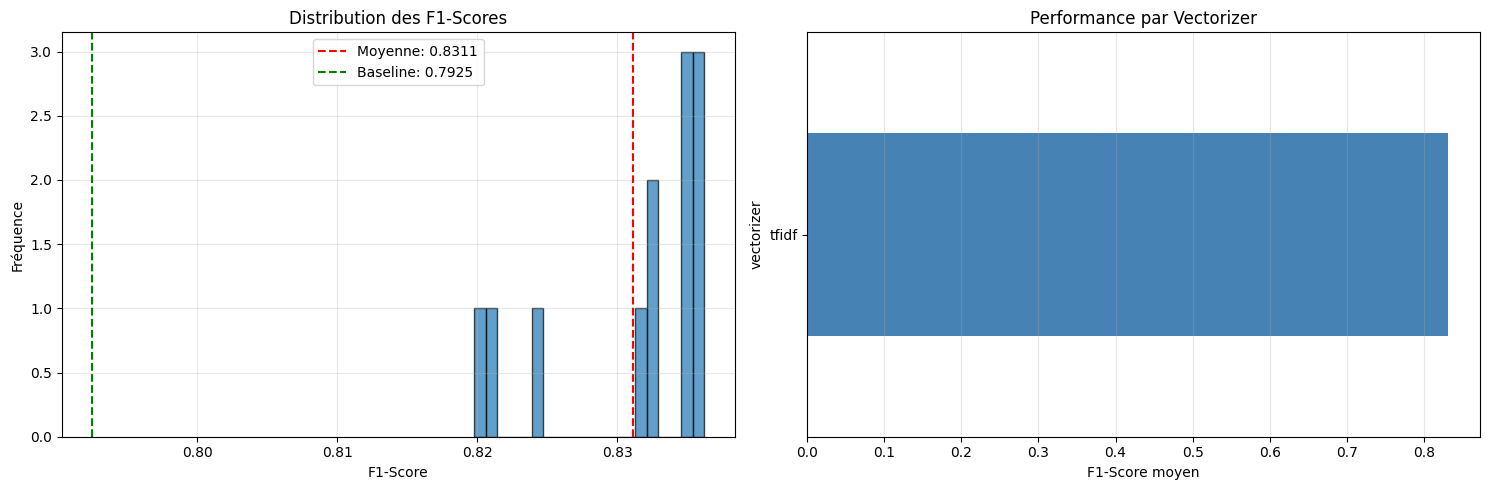

In [15]:
# Analyser grid results
analyze_experiment_results(
    grid_results,
    baseline_f1=baseline_f1,
    show_plot=True
)

## 10. Configuration Optimale

Identification et sauvegarde de la meilleure configuration

In [16]:
# Meilleure configuration
best = grid_results.iloc[0]

print("="*80)
print("🏆 CONFIGURATION OPTIMALE")
print("="*80)
print(f"Vectorizer: {best['vectorizer'].upper()}")
print(f"Max features: {best['max_features']}")
print(f"N-gram range: {best['ngram_range']}")
print(f"Features manuelles: {'Oui' if best['use_features'] else 'Non'}")
print(f"\nPerformance:")
print(f"  F1-Score: {best['f1_score']:.4f}")
print(f"  Accuracy: {best['accuracy']:.4f}")
improvement_vs_baseline = (best['f1_score'] - baseline_f1) / baseline_f1 * 100
print(f"  Amélioration vs baseline: {improvement_vs_baseline:+.2f}%")
print("="*80)

🏆 CONFIGURATION OPTIMALE
Vectorizer: TFIDF
Max features: 20000
N-gram range: (1, 1)
Features manuelles: Oui

Performance:
  F1-Score: 0.8362
  Accuracy: 0.8355
  Amélioration vs baseline: +5.51%


## 11. Export Configuration

Sauvegarder pour Notebook 03

In [17]:
# Construire le dictionnaire de configuration
import ast

ngram_tuple = ast.literal_eval(best['ngram_range']) if isinstance(best['ngram_range'], str) else best['ngram_range']

BEST_CONFIG = {
    'vectorizer_type': best['vectorizer'],
    'strategy': 'split',
    'text_columns': ['title_clean', 'desc_clean'],
    'feature_columns': feature_columns if best['use_features'] else None,
    'max_features_title': int(best['max_features']),
    'max_features_desc': int(best['max_features']),
    'ngram_range': ngram_tuple,
    'title_weight': float(best.get('title_weight', 1.0)),
    'min_df': 2,
    'max_df': 0.95
}

# Sauvegarder
save_vectorization_config(
    BEST_CONFIG,
    'results/configs/best_vectorization_config.json',
    metadata={
        'f1_score': float(best['f1_score']),
        'accuracy': float(best['accuracy']),
        'train_time': float(best['train_time']),
        'notebook': '02_Vectorization_Strategies.ipynb',
        'baseline_f1': baseline_f1,
        'improvement_pct': float(improvement_vs_baseline),
        'title_weight': float(best.get('title_weight', 1.0))
    }
)

print("\n✓ Configuration exportée vers: results/configs/best_vectorization_config.json")
print("✓ Prête pour Notebook 03 (Model Selection)")

✓ Configuration sauvegardée: results/configs/best_vectorization_config.json

✓ Configuration exportée vers: results/configs/best_vectorization_config.json
✓ Prête pour Notebook 03 (Model Selection)


## 12. Conclusions & Rapport Final

**Génération automatique** du rapport complet avec:
- ✅ Tracking global de tous les scores
- ✅ Vérification de l'optimalité de la configuration
- ✅ Résumé détaillé des 5 découvertes principales
- ✅ Performance finale et prochaines étapes

Le rapport est affiché ci-dessous et sauvegardé dans `results/vectorization_report.txt`.

In [18]:
# ============================================================================
# GÉNÉRATION DU RAPPORT COMPLET
# ============================================================================

report = generate_vectorization_report(
    df_vec=df_vec,
    results_weighting=results_weighting,
    results_strategies=results_strategies,
    grid_results=grid_results,
    result_tfidf=result_tfidf,
    result_merged=result_merged,
    baseline_f1=baseline_f1,
    save_report=True,
    report_path='results/vectorization_report.txt',
    verbose=True
)

# Résumé rapide
print("\n" + "="*80)
print("RÉSUMÉ RAPIDE")
print("="*80)
print(f"✓ Configuration optimale: {'✅ OUI' if report['is_optimal'] else '⚠️ NON'}")
print(f"✓ Meilleur F1 score: {report['best_score']:.4f}")
print(f"✓ Baseline F1: {report['baseline_score']:.4f}")
print(f"✓ Amélioration totale: +{report['total_improvement_pct']:.2f}%")
print(f"\n✓ Rapport sauvegardé: results/vectorization_report.txt")
print(f"✓ Tracking sauvegardé: results/all_scores_tracking.csv")
print("="*80)


✓ Rapport sauvegardé: results/vectorization_report.txt

📊 RAPPORT DE VECTORISATION - PHASE 2
Généré le: 2025-12-17 21:05:41
Total expériences: 24

RÉSUMÉ DES DÉCOUVERTES

1️⃣  Count vs TF-IDF
   → TF-IDF (F1=0.8246) surpasse Count (F1=0.8167)
   → Amélioration: +0.97%

2️⃣  Split vs Merged
   → Split (F1=0.8246) surpasse Merged (F1=0.7848)
   → Amélioration: +5.07%

3️⃣  Pondération du Titre
   → Poids optimal: 1.5x
   → F1 = 0.8256 (baseline 1.0x: 0.8246)
   → Amélioration: +0.12%

4️⃣  Features Manuelles
   → Sans features: F1 = 0.8246
   → Avec features: F1 = 0.8284
   → Amélioration: +0.46%

5️⃣  Hyperparamètres Optimaux
   → Vectorizer: TFIDF
   → Max features: 20,000
   → N-gram range: (1, 1)
   → Title weight: 1.5x
   → Features manuelles: Oui
   → F1 Final: 0.8362

🏆 PERFORMANCE FINALE
Baseline (raw data, NB01):              F1 = 0.7925
Meilleur score (configuration finale):  F1 = 0.8362
Amélioration totale:                    +5.51%

Statut: ✅ Configuration optimale validée



## 13. Évaluation Finale sur Hold-out Test Set

**Évaluation finale** de la configuration optimale sur le hold-out test set.

In [20]:
print("=" * 80)
print("ÉVALUATION FINALE SUR HOLD-OUT TEST SET")
print("=" * 80)

# Entraîner sur TOUT le development set avec la config optimale
print("\nEntraînement sur development set complet...")

# Préparer merged column pour holdout
df_holdout['text_merged'] = df_holdout['title_clean'] + ' ' + df_holdout['desc_clean']

# Utiliser la meilleure config
final_result = run_single_experiment(
    df_dev,  # Train sur TOUT le development set
    df_holdout,  # Test sur hold-out
    y_dev,
    y_holdout,
    vectorizer_type=best['vectorizer'],
    strategy='split',
    text_columns=['title_clean', 'desc_clean'],
    feature_columns=feature_columns if best['use_features'] else None,
    max_features=int(best['max_features']),
    ngram_range=ngram_tuple,
    title_weight=float(best.get('title_weight', 1.0)),
    model_name='logreg',
    verbose=True
)

print("\n" + "=" * 80)
print("RÉSULTATS FINAUX")
print("=" * 80)
print(f"F1-Score (validation):  {best['f1_score']:.4f}")
print(f"F1-Score (hold-out):    {final_result['f1_score']:.4f}")
diff = final_result['f1_score'] - best['f1_score']
print(f"Différence:             {diff:+.4f} ({diff/best['f1_score']*100:+.2f}%)")
print("=" * 80)

# Sauvegarder
final_eval = {
    'val_f1': float(best['f1_score']),
    'holdout_f1': float(final_result['f1_score']),
    'difference': float(diff),
    'config': BEST_CONFIG
}

import json
with open('results/final_vectorization_holdout.json', 'w') as f:
    json.dump(final_eval, f, indent=2)

print("\n✓ Résultat final sauvegardé: results/final_vectorization_holdout.json")

ÉVALUATION FINALE SUR HOLD-OUT TEST SET

Entraînement sur development set complet...

Expérience: TFIDF + LOGREG
  Strategy: split
  Max features: 20000
  N-gram range: (1, 1)
  Features manuelles: Oui

Entraînement du pipeline...


✓ Entraînement terminé en 51.25s

RÉSULTATS DE L'ÉVALUATION
F1-Score (weighted): 0.8445
Accuracy:            0.8446
Temps prédiction:    1.16s

Rapport de classification:
--------------------------------------------------------------------------------
                        precision    recall  f1-score   support

     Livres techniques       0.51      0.61      0.56       467
          Rétro Gaming       0.75      0.72      0.73       376
        Accessoires JV       0.84      0.84      0.84       252
              Consoles       0.91      0.81      0.86       125
              Figurine       0.80      0.82      0.81       401
Cartes à collectionner       0.93      0.96      0.95       593
          Jeux de rôle       0.78      0.53      0.63       115
    Jouets & Figurines       0.77      0.78      0.77       731
        Jeux éducatifs       0.70      0.55      0.61       311
    Modélisme & Drones       0.98      0.96      0.97       757
           Bébé & Jeux       0.99      0.95